In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm_notebook
from PIL import Image
import json
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

## Load model and utils

In [25]:
%run config.ipynb
#from config import *
%run data.ipynb
#from data import *
%run image_model.ipynb
#from image_model import *
%run sequence_model.ipynb
#from sequence_model import *
%run joint_model.ipynb
#from joint_model import *
%run utils.ipynb
#from utils import *

## print category dictionary

In [26]:
fd = open('categories_dict.json')
name_dict = json.load(fd)
print(name_dict)
output = []

{u'24': u'streetlight', u'25': u'drums', u'26': u'camouflage', u'27': u'grass', u'20': u'matches', u'21': u'aircraft carrier', u'22': u'camel', u'23': u'saxophone', u'28': u'snorkel', u'29': u'laptop', u'0': u'squiggle', u'4': u'eyeglasses', u'8': u'zebra', u'59': u'flashlight', u'58': u'bottlecap', u'55': u'castle', u'54': u'backpack', u'57': u'sword', u'56': u'couch', u'51': u'yoga', u'50': u'sleeping bag', u'53': u'cup', u'52': u'owl', u'88': u'calculator', u'89': u'basketball', u'82': u'fork', u'83': u'remote control', u'80': u'pig', u'81': u'triangle', u'86': u'mermaid', u'87': u'moustache', u'84': u'finger', u'85': u'onion', u'3': u'bush', u'7': u'shovel', u'39': u'pear', u'38': u'compass', u'33': u'flying saucer', u'32': u'passport', u'31': u'car', u'30': u'hot tub', u'37': u'helicopter', u'36': u'apple', u'35': u'cactus', u'34': u'lobster', u'60': u'suitcase', u'61': u'key', u'62': u'jacket', u'63': u'The Mona Lisa', u'64': u'tooth', u'65': u'goatee', u'66': u'headphones', u'67

## Load data

In [15]:
# generate data loader
train_loader = get_loader(train=True, image=IMAGE_MODE, sequence=SEQUENCE_MODE)
val_loader = get_loader(val=True, image=IMAGE_MODE, sequence=SEQUENCE_MODE)
test_loader = get_loader(test=True, image=IMAGE_MODE, sequence=SEQUENCE_MODE)

## init tensorboard

In [16]:
# Tensorboard
from tensorboardX import SummaryWriter
print('Experiment Setting: ', model_name)
writer = SummaryWriter('runs/'+model_name+('_test' if Test_Mode else '_train'))

('Experiment Setting: ', 'models/baseline_sequence_new')


In [17]:
def main():
    # model
    if IMAGE_MODE and SEQUENCE_MODE:
        Net = JointNet
    else:
        Net = ImageNet if IMAGE_MODE else SequenceNet
    model = Net().cuda()
    
    # optimizer and scheduler
    optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=initial_lr)
    scheduler = lr_scheduler.ExponentialLR(optimizer, 0.5**(1 / lr_halflife))
    start_epoch = 0
    
    if Test_Mode:
        resume = torch.load(Test_Model)
        model.load_state_dict(resume['weights'])
        test_ac = test(model, test_loader, optimizer, scheduler, resume['epoch'], train=False)
        return
    
    for i in range(num_epoch):
        #'Training epoch: '
        train_ac = test(model, train_loader, optimizer, scheduler, i, train=True)
        #'Evaluation epoch: '
        val_ac = test(model, val_loader, optimizer, scheduler, i, train=False)
        
        #save model
        results = {
            'epoch':i,
            'weights':model.state_dict(),
            'training accuracy': train_ac,
            'eval accuracy':val_ac,
        }
        torch.save(results, model_name + '_' + str(i) + '.pth')
        

## Test, save visualized image-label pair, record results

In [18]:
def test(model, loader, optimizer, scheduler, epoch, train=False):
    if train:
        model.train()
    else:
        model.eval()
    
     # container
    output_container = []
    loss_container = []
    
    loader = tqdm_notebook(loader, desc='Training epoch '+str(epoch) if train else 'Eval epoch '+str(epoch))
    batch_max = len(loader)
    batch_count = 0
    for v, s, l in loader:
        var_params = {
            'requires_grad': False,
        }
        v = Variable(v.cuda(async=True), **var_params) # image
        s = Variable(s.cuda(async=True), **var_params) # sequence
        l = Variable(l.cuda(async=True), **var_params) # label
        
        out = model(v, s)
        if train:
            loss = F.cross_entropy(out, l)
            acc = (l == out.max(1)[1]).float().mean()
            output_container.append(float(acc.detach().data))
            loss_container.append(float(loss.detach().data))
            scheduler.step()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Add Tensorboard log
            add_log(writer, epoch*batch_max+batch_count, loss_container, output_container, train=True)
        else:
            label_idx = int(out.max(1)[1][0])
            label = name_dict[str(label_idx)]
            name = 'images/' + str(batch_count) + '_' + str(label) + '.png'
            single_draw = v[0].view(28,28).data.cpu().numpy().astype(dtype = np.uint8)
            image_draw = Image.fromarray(single_draw, 'P')
            image_draw.save(name)
            
            global output
            match = (l == out.max(1)[1])
            acc = (match).float().mean()
            output_container.append(float(acc))
            output = output + match.float().data.cpu().numpy().tolist()
            # Add Tensorboard log
            add_log(writer, epoch*batch_max+batch_count, loss_container, output_container, test=True)
            
        # visualization
        loader.set_postfix(loss=list_mean(loss_container), acc=list_mean(output_container))
        
        batch_count+=1
    
    return list_mean(output_container)

In [19]:
test()

SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dSdFdmFsIGVwb2NoIDYnLCBtYXg9MTk1NCwgc3R5bGU9UHJvZ3Jlc3NTdHlsZShkZXNjcmlwdGlvbl93aWTigKY=


## each class performance

In [20]:
output_dict = {}
for i in range(100):
    print(name_dict[str(i)]+' : '+ str(sum(output[i*10000:i*10000+10000]) / 10000))
    output_dict[name_dict[str(i)]] = sum(output[i*10000:i*10000+10000]) / 10000

squiggle : 0.7995
bread : 0.7822
violin : 0.8345
bush : 0.8212
eyeglasses : 0.95
soccer ball : 0.9325
string bean : 0.8352
shovel : 0.8731
zebra : 0.8584
kangaroo : 0.92
spoon : 0.8885
submarine : 0.8959
underwear : 0.8337
hot air balloon : 0.9137
pickup truck : 0.8526
snowman : 0.9765
chair : 0.9654
cloud : 0.8885
giraffe : 0.9273
axe : 0.8713
matches : 0.8095
aircraft carrier : 0.6909
camel : 0.9409
saxophone : 0.9186
streetlight : 0.9331
drums : 0.9005
camouflage : 0.8321
grass : 0.965
snorkel : 0.8917
laptop : 0.952
hot tub : 0.8593
car : 0.9558
passport : 0.9084
flying saucer : 0.881
lobster : 0.7896
cactus : 0.9595
apple : 0.94
helicopter : 0.9481
compass : 0.8746
pear : 0.9003
cannon : 0.8829
spider : 0.951
fan : 0.9033
bandage : 0.8983
cruise ship : 0.8787
blueberry : 0.811
crab : 0.8462
elbow : 0.899
cooler : 0.8101
circle : 0.9347
sleeping bag : 0.8452
yoga : 0.8987
owl : 0.9498
cup : 0.9181
backpack : 0.9208
castle : 0.9254
couch : 0.9174
sword : 0.9445
bottlecap : 0.8278
fl

## best/worst performance

In [21]:
best = None
worst = None
best_score = -1
worst_score = 1
for c,a in output_dict.items():
    if a > best_score:
        best_score = a
        best = c
    if a < worst_score:
        worst_score = a
        worst = c
print('best: '+best+'->'+str(best_score))
print('worst: '+worst+'->'+str(worst_score))

best: snowman->0.9765
worst: cello->0.6564


In [22]:
list_ac = list(output_dict.values())

## histogram of results

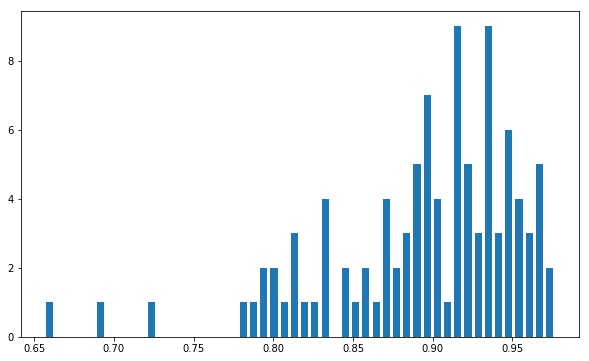

In [23]:
hist, bins = np.histogram(list_ac, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
figure(figsize=(10, 6))
plt.bar(center, hist, align='center', width=width)
plt.show()

In [24]:
sum(list_ac)

89.35000000000002